In [2]:
import trackpy as tp
import pims
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from scipy.spatial import voronoi_plot_2d
from scipy.spatial import Voronoi as ScipyVoronoi
from scipy.spatial import distance
from pandas import DataFrame, Series  # for convenience

D:\Softwares\coding\python\miniconda\envs\python_3.9\lib\site-packages\pims\image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


In [3]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open('C:/Users/92163/Desktop/some paper/intern/SCI_2/SCI_2.mov'))
pic=gray(pims.open('C:/Users/92163/Desktop/some paper/intern/SCI_2/25.png'))

In [4]:
video=[]
i=0
for frame in frames[:]:
    video.append(frame[0:292,:]/255)  


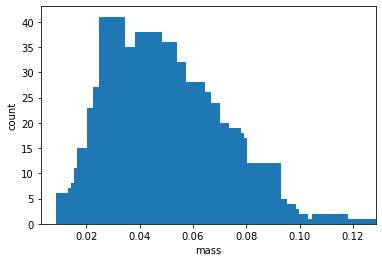

In [34]:
f=tp.locate(video[0],3,invert=True,)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100,width=0.01)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

确认好了video的参数，开始batch

In [88]:
f = tp.batch(video[500:1000], 3,invert=True,processes=4,minmass=0.042)

Frame 999: 590 features


In [89]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,2.257042,89.922535,0.056191,0.811450,0.737968,0.019192,0.792157,-0.251698,500
1,2.285285,123.786787,0.065886,0.797895,0.674528,0.023941,0.572549,-0.163511,500
2,1.883191,137.025641,0.069448,0.712125,1.511236,0.034229,0.376471,-0.124549,500
3,2.205195,358.989610,0.076175,0.750757,1.046083,0.033240,0.443137,-0.135529,500
4,2.213058,363.865979,0.057576,0.725102,1.091503,0.027304,0.447059,-0.136235,500
...,...,...,...,...,...,...,...,...,...
382578,286.911538,369.846154,0.106229,0.815711,0.034682,0.035546,0.188235,-0.095924,999
382579,287.864769,63.081851,0.057404,0.854130,0.297561,0.015526,0.800000,-0.254879,999
382580,289.212544,178.885017,0.058630,0.732520,0.292208,0.027170,0.262745,-0.103809,999
382581,288.887324,280.235915,0.058017,0.704613,1.560284,0.029213,0.156863,-0.092952,999


In [97]:
f['frame']

0         500
1         500
2         500
3         500
4         500
         ... 
382578    999
382579    999
382580    999
382581    999
382582    999
Name: frame, Length: 382583, dtype: int64

计算H_Ndist:

In [90]:
H=[]

定义几个函数：

In [8]:
# 3. define a function to convert adjancency_list (e.g.2D array:[[0,1],[0,2],[1,2]]) which means particle 0 connect with 1 and 2, and particle 1 also connect to particle 2) into adjancency_matrix
#[011
# 101
# 110]   note: this should be a symmetric matrix

def neighbour_pair_list_to_matrix(num_of_pts, nlist):
    """
    :param num_of_pts: number of points (boids, rafts...)
    :param nlist: neighbour list; shape (num_of_pts, 2); integer are row# (or col#) of position array
    :return: ngb_mask: neighbour mask array
    """
    ngb_mask = np.zeros((num_of_pts, num_of_pts))
    ngb_mask[nlist[:, 0], nlist[:, 1]] = 1
    ngb_mask[nlist[:, 1], nlist[:, 0]] = 1
    # use np.allclose() to check if the array is symmetric.
    #np.allclose(ngb_mask, ngb_mask.T)
    return ngb_mask


In [9]:
#5. define a function to calculate the H_ndist
def compute_h_ndist(ndistances, bin_edges):
    """
    :param ndistances: neighbour distances
    :param bin_edges: bin edges
    :return: (h_ndist, h_ndist_adjusted, h_ndist_normalized)
    """
    c, edge_arr = np.histogram(ndistances, bin_edges)
    w = edge_arr[1:] - edge_arr[:-1]  # width of bins
    p = c / np.float32(np.sum(c))
    p_nonzero = p[np.nonzero(p)]
    w_nonzero = w[np.nonzero(p)]
    h_ndist = - np.sum(p_nonzero * np.log2(p_nonzero))
    h_ndist_adjusted = -np.sum(p_nonzero * np.log2(p_nonzero/w_nonzero))
    h_ndist_normalized = h_ndist_adjusted / np.log2(w_nonzero.sum())
    return h_ndist, h_ndist_adjusted, h_ndist_normalized

In [93]:
#1. save the positon of particles and calculate the pair distance matrix
for i in range(500,1000):
    data=f[f['frame']==i]
    position_saved=data.values[:,0:2]
    pairwise_distance_matrix = distance.cdist(position_saved[:,:],
                                                    position_saved[:,:], 'euclidean') 
#2. we need to import Voronoi package to define neighbor list
    vor = ScipyVoronoi(position_saved)
    neighbour_pairs = vor.ridge_points
    
#3.convert adjancency_list    
    n=len(neighbour_pairs)
    neighbour_pairs_mask = neighbour_pair_list_to_matrix(n, neighbour_pairs)

    #print(np.allclose(neighbour_pairs_mask,neighbour_pairs_mask.T)) #check if symmetric
    
#4. use the adjancency mask to get rid of pair-distance of whom are not neighbors 
    neighbour_distances = pairwise_distance_matrix[np.nonzero(neighbour_pairs_mask)]
    
#5.calculate the H_ndist
    bin_edges_ndist = np.arange(0, 300, 2).tolist()   #the bin edge is kind of an emperical parameter which need to be tuned

    # calculate the H_Ndist and draw the histogram of neighbor_distances
    H_NDist, H_NDist_adj, H_NDist_norm = compute_h_ndist(neighbour_distances, bin_edges_ndist)
    count, edge_arr = np.histogram(neighbour_distances, bin_edges_ndist)
    H.append(H_NDist_norm)

绘制折线图

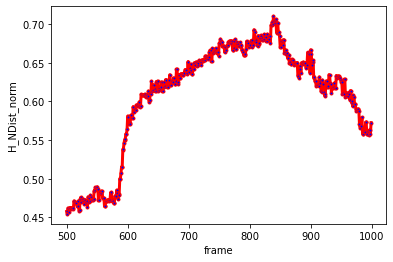

In [96]:
x=range(500,1000)
y=H
plt.plot(x,y,linewidth=3,color='r',marker='o',markerfacecolor='blue',markersize=3)
plt.xlabel('frame')
plt.ylabel('H_NDist_norm')
plt.show()

调整？

In [6]:
f1 = tp.batch(video[500:855], 3,invert=True,processes=4,minmass=0.042)

Frame 854: 700 features


In [7]:
f2= tp.batch(video[855:1000], 3,invert=True,processes=4)

Frame 999: 620 features


In [16]:
H1=[]

In [17]:
#1. save the positon of particles and calculate the pair distance matrix
for i in range(500,1000):
    if i<855:
        data=f1[f1['frame']==i]
    if i>854:
        data=f2[f2['frame']==i]
    position_saved=data.values[:,0:2]
    pairwise_distance_matrix = distance.cdist(position_saved[:,:],
                                                    position_saved[:,:], 'euclidean') 
#2. we need to import Voronoi package to define neighbor list
    vor = ScipyVoronoi(position_saved)
    neighbour_pairs = vor.ridge_points
    
#3.convert adjancency_list    
    n=len(neighbour_pairs)
    neighbour_pairs_mask = neighbour_pair_list_to_matrix(n, neighbour_pairs)

    #print(np.allclose(neighbour_pairs_mask,neighbour_pairs_mask.T)) #check if symmetric
    
#4. use the adjancency mask to get rid of pair-distance of whom are not neighbors 
    neighbour_distances = pairwise_distance_matrix[np.nonzero(neighbour_pairs_mask)]
    
#5.calculate the H_ndist
    bin_edges_ndist = np.arange(0, 300, 2).tolist()   #the bin edge is kind of an emperical parameter which need to be tuned

    # calculate the H_Ndist and draw the histogram of neighbor_distances
    H_NDist, H_NDist_adj, H_NDist_norm = compute_h_ndist(neighbour_distances, bin_edges_ndist)
    count, edge_arr = np.histogram(neighbour_distances, bin_edges_ndist)
    H1.append(H_NDist_norm)

In [18]:
 len(H1)

500

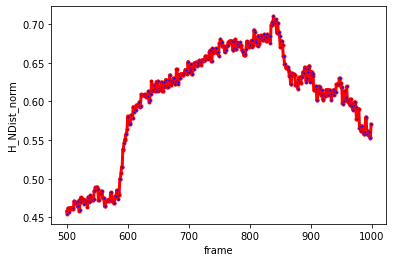

In [19]:
x=range(500,1000)
y=H1
plt.plot(x,y,linewidth=3,color='r',marker='o',markerfacecolor='blue',markersize=3)
plt.xlabel('frame')
plt.ylabel('H_NDist_norm')
plt.show()